# Parametric Dynamic Mode Decomposition - DYNASTY Loop (RELAP5)
The RELAP5 model of the DYNASTY circulation loop is used to test the pDMD. Four different versions will be compared in this notebook:

1. Reduced Operator Interpolation with standard DMD - (rOp)
2. Reduced Koopman Operator Interpolation with OptDMD (rKOp)
3. Monolithic pDMD from pyDMD  - (pDMD-mono)
4. Partitioned pDMD from pyDMD - (pDMD-part)

The snapshots are loaded from `data/dynasty_1param.pkl`, which contains the temperature field of the loop at different values of power provided to the system. The data is a dictionary and will here decompressed.

Note the following nomenclature:
* $N_s$ = number of training parameters
* $\mathcal{N}_h$ = spatial discretisation
* $N_t$ = time discretisation

In [2]:
import pickle
import numpy as np

data_dict = pickle.load(open('../data/dynasty_1param.pkl','rb'))

key_names = list(data_dict.keys())
param_values = np.asarray([float(key_names[i].split()[-1]) for i in range(len(key_names))])
dataset_time = data_dict[key_names[0]].columns.to_numpy()

num_params = len(param_values)
num_spatial, num_time = data_dict[key_names[0]].to_numpy().shape

domain = np.arange(0, num_spatial).reshape(-1,1)

print('Size of the starting dataset:')
print(f'Number of parameters = {num_params}')
print(f'Spatial discretisation = {num_spatial}')
print(f'Time discretisation = {num_time}')

Size of the starting dataset:
Number of parameters = 20
Spatial discretisation = 122
Time discretisation = 201


Define the actual size of the training dataset. Here you can specify:
* `start_idx`: the index corresponding to the time instant you want to start training from (default value `0` = start from the very beginning).
* `end_idx`: the index corresponding to the time instant you want to end your training phase at (default value `None` = finish at the latest available time).
* `sampling_step`: the step at which you sample your starting data (default value `1` = include all snapshots within `start_idx` and `end_idx`).

In this Notebook, we set `start_idx = 30` to remove from the dataset the initial stationary data (representing a 'stabilisation time' for the system to reach a stationary initial condition), and `end_idx = 185` to perform forecasting on the last snapshots.

In [3]:
start_idx = 40
end_idx = 181
sampling_step = 1

train_time = dataset_time[start_idx:end_idx:sampling_step]
pred_time  = dataset_time[start_idx::sampling_step]

Nt_train = len(train_time)
Nt_pred  = len(pred_time)

print(f'Training dataset boundaries: [{train_time[0]}, {train_time[-1]}]')

Training dataset boundaries: [1400.0, 2800.0]


Create the snapshot matrix, shaped as $N_s \times N_t \times\mathcal{N}_h$.

In [4]:
snaps = np.zeros((num_params, Nt_pred, num_spatial))
for ii in range(num_params):
    snaps[ii] = data_dict[key_names[ii]].to_numpy()[:, start_idx::sampling_step].T

print(f'Dimension of the starting data matrix: {snaps.shape}')

Dimension of the starting data matrix: (20, 161, 122)


Here the plotter class is defined

In [5]:
# Define plotter class
import sys
sys.path.append('../')

from tools.plots import PlotDYNASTY

plotter = PlotDYNASTY(domain)

Visualize one of the snapshots (specify `plot_index` to plot the 2D time-space snapshots for different values of the parameters).


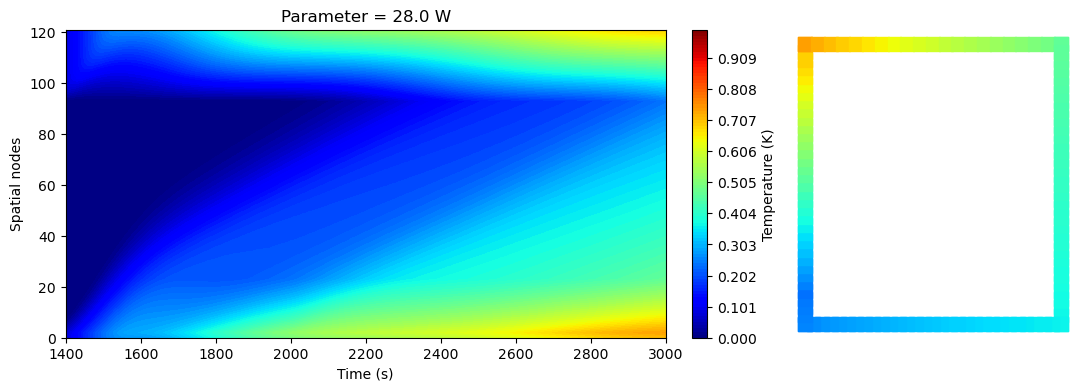

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

param_to_plot = np.random.choice(num_params, 1, replace=False)[0]

levels = np.linspace(0, 1, 100)
cmap = cm.jet

fig = plt.figure(figsize=(13, 4))  # Overall figure size
gs = GridSpec(1, 2, width_ratios=[7, 3], wspace=0.15)  # Define the grid layout

# Create the axes with specified sizes
ax1 = fig.add_subplot(gs[0, 0])  # First subplot (10x3)
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot (3x3)

cont = plotter.plot_contour(ax1, snaps[param_to_plot].T, pred_time, show_ticks=True, levels=levels, cmap=cmap)
fig.colorbar(cont, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04, label='Temperature (K)')

ax1.set_title(f'Parameter = {param_values[param_to_plot]} W')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Spatial nodes')

sc = plotter.plot_loop(ax2, snaps[param_to_plot, -1], vmin=levels[0], vmax=levels[-1], cmap=cmap)

plt.tight_layout()

Here the path for results is defined

In [7]:
import os
path_res = 'Results/DYNASTY_1param/'
os.makedirs(path_res, exist_ok=True)

Let us define the train and test set for the input power $P$

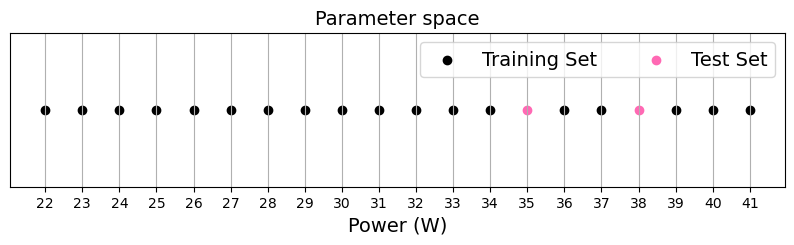

In [8]:
from sklearn.model_selection import train_test_split

test_size = 0.1

train_params, test_params, train_snapshots, test_snapshots = train_test_split(param_values, snaps, test_size = test_size, random_state = 20)

# Sort the training and test sets
train_argsort = np.argsort(train_params)
test_argsort = np.argsort(test_params)

train_params = train_params[train_argsort]
test_params = test_params[test_argsort]

train_snapshots = train_snapshots[train_argsort]
test_snapshots = test_snapshots[test_argsort]

num_params = len(train_params)

plt.figure(figsize = (10,2))
plt.scatter(train_params,np.zeros_like(train_params), c = 'black', label = 'Training Set')
plt.scatter(test_params,np.zeros_like(test_params), c = 'hotpink', label = 'Test Set' )
plt.xlabel('Power (W)', fontsize = 14)
plt.yticks([])
plt.xticks(param_values)
plt.title('Parameter space', fontsize = 14)
plt.grid()
plt.legend(ncols = 2, loc = 'best', fontsize = 14)

plt.savefig(path_res + 'parameter_space.pdf', dpi = 300, bbox_inches = 'tight')

The data are saved as
\begin{equation*}
  N_p^{train} \times N_t^{train} \times N_h \qquad\text{ and } \qquad N_p^{test} \times N_t \times N_h
\end{equation*}

In [9]:
train_snapshots = train_snapshots[:, :end_idx - start_idx:sampling_step, :]

print('Size of the training dataset:', train_snapshots.shape)
print('Size of the test dataset:', test_snapshots.shape)

Size of the training dataset: (18, 141, 122)
Size of the test dataset: (2, 161, 122)


## Preliminary SVD to assess the rank
The snapshot matrix $\mathbb{S}$ is reduced through a linear compression performed with the Singular Value Decomposition (SVD):
\begin{equation*}\mathbb{U},\Sigma,\mathbb{V}^T = \text{svd}(\mathbb{S})\end{equation*}

In [10]:
from sklearn.utils.extmath import randomized_svd

rank = 50
spatial_modes, sing_vals, _ = randomized_svd(train_snapshots.reshape(-1, num_spatial).T, n_components=rank, n_iter='auto')

Let us plot the eigenvalues

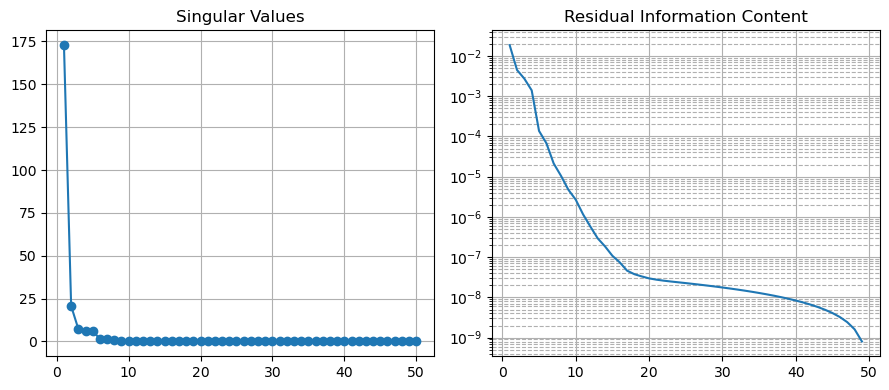

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].plot(np.arange(1, rank+1, 1), sing_vals, '-o')
axs[0].set_title('Singular Values')

axs[1].semilogy(np.arange(1, rank, 1), 1-np.cumsum(sing_vals[:-1]**2) / np.sum(sing_vals**2), '-')
axs[1].set_title('Residual Information Content')

for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')

plt.tight_layout()
fig.savefig(path_res + 'svd_analysis.pdf', format='pdf', dpi=200, bbox_inches='tight')

Let us compute the reduced coefficient from which the DMD models will be created. 

Given the snapshot matrix $\mathbb{X}\in\mathbb{R}^{\mathcal{N_h}\times(N_t\cdot N_s^{train})}$, the reduced coefficient is computed as $\mathbb{V} = \mathbb{U}^T\mathbb{X}$, where $\mathbb{U}\in\mathbb{R}^{\mathcal{N}_h\times r}$ is the matrix containing the spatial SVD modes and $\mathbb{V}\in\mathbb{R}^{r\times (N_t\cdot N_s^{train})}$ - same for test set.

In [12]:
train_pod_coeff = np.dot(spatial_modes.T, train_snapshots.reshape(-1, num_spatial).T) # rank x (Nt * Ns_train)
test_pod_coeff  = np.dot(spatial_modes.T, test_snapshots.reshape(-1, num_spatial).T)  # rank x (Nt * Ns_test)

# Reshape the POD coefficients
train_pod_coeff = train_pod_coeff.T.reshape(len(train_params), Nt_train, rank)
test_pod_coeff  = test_pod_coeff.T.reshape(len(test_params), Nt_pred, rank)

Let us make a plot of the SVD modes

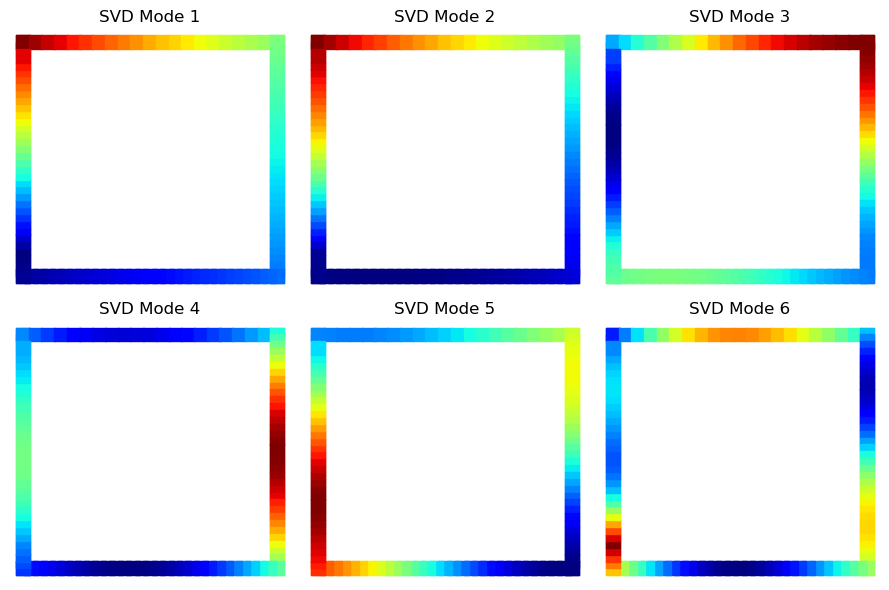

In [13]:
cmap = cm.jet

nrows = 2
ncols = 3

modes_to_plot = np.arange(0, 6, 1)

assert len(modes_to_plot) == nrows * ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
axs = axs.flatten()

for ii, idx in enumerate(modes_to_plot):
    plotter.plot_loop(axs[ii], spatial_modes[:, idx], cmap = cmap)
    axs[ii].set_title(f'SVD Mode {idx+1}')

plt.tight_layout()

fig.savefig(path_res + 'spatial_modes.png', format='png', dpi=200, bbox_inches='tight')

Let us make a plot of the reduced coefficient for a random training coefficient

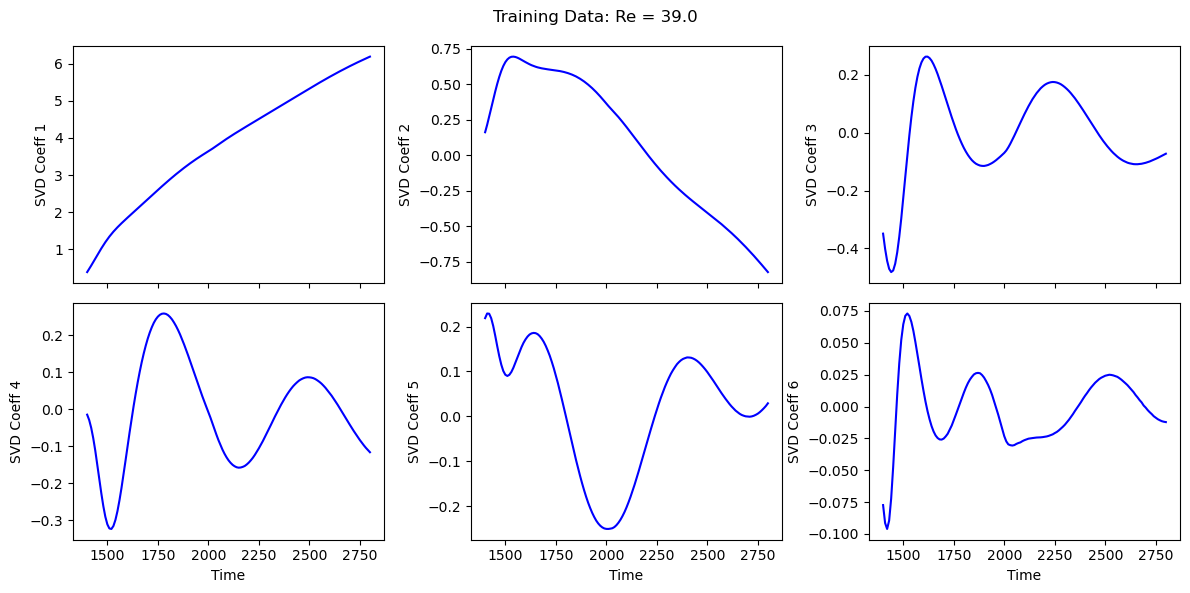

In [14]:
param_to_plot = np.random.choice(len(train_params), 1, replace=False)

fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=(4 * ncols, 3 * nrows))
axs = axs.flatten()

for ii, idx in enumerate(modes_to_plot):
    axs[ii].plot(train_time, train_pod_coeff[param_to_plot, :, idx].T, 'b', label='P = %.2f' % train_params[param_to_plot])
    axs[ii].set_ylabel(f'SVD Coeff {idx+1}')

    if ii >= (nrows-1)*ncols:
        axs[ii].set_xlabel('Time')

fig.suptitle(f'Training Data: Re = {train_params[param_to_plot][0]}')
plt.tight_layout()

## Reduced Operator Interpolation with standard DMD - rOp

This version builts DMD models (with standard algorithm) for each training parameters and then interpolates the DMD operators to predict the test set.

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tools.backends import ReducedOperatorInterpolation

rank_roi = 8
roi = ReducedOperatorInterpolation(rank = rank_roi)
roi.fit(train_pod_coeff, train_time=train_time, test_time=pred_time, verbose=True, scaler=MinMaxScaler())

Let us make some contour plots of the reconstruction of the DMD models for training parameters

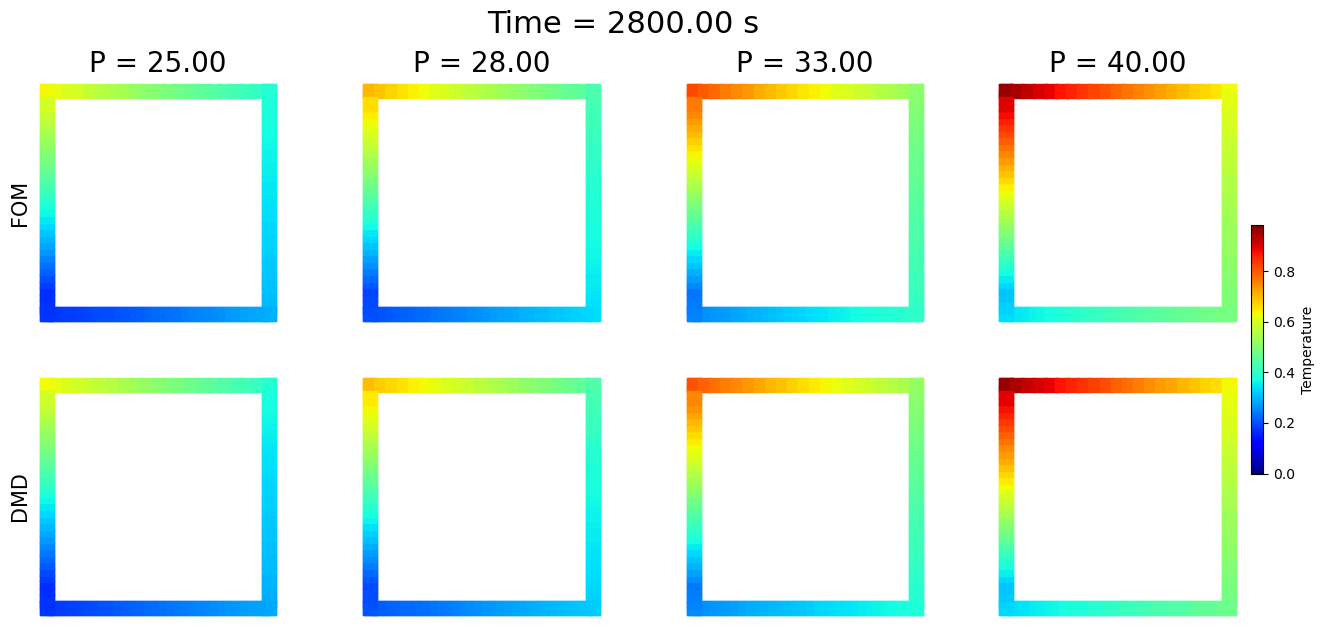

In [16]:
from tools.backends import dmd_reconstruct
from IPython.display import clear_output as clc

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_params), 4, replace=False))

recons = [[dmd_reconstruct(roi.dmds[mu_i], spatial_modes[:, :roi.rank], scaler = roi.scaler, time=None) for mu_i in params_to_plot]]

labels = ['DMD']

for tt in range(0, len(train_time), 10):
    fig, axs = plotter.plotting_loop_rec( params_to_plot, train_snapshots, train_params, train_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)

    clc(wait=True)
    plt.show()
    plt.close(fig)

### Reduction of the DMD operators
Once a DMD model has been built for each parametric realization, we are looking for a generic parametric representation of the DMD models. The operators are collected and reshaped in $\mathbb{A} = \begin{bmatrix} \mathbb{A}_1 & \mathbb{A}_2 & \cdots & \mathbb{A}_{N_s} \end{bmatrix}$, where $\mathbb{A}_i\in\mathbb{R}^{r\times r}$ is the DMD operator for the $i$-th parametric realization so that we can compress the DMD operators using the SVD

In [17]:
roi.reduce_operators(rank_op_svd=len(train_params))
roi.get_op_interpolants(train_params, interp='cubic')

Let us observe if the latent dynamics is well reconstructed by the pDMD method for test parameters

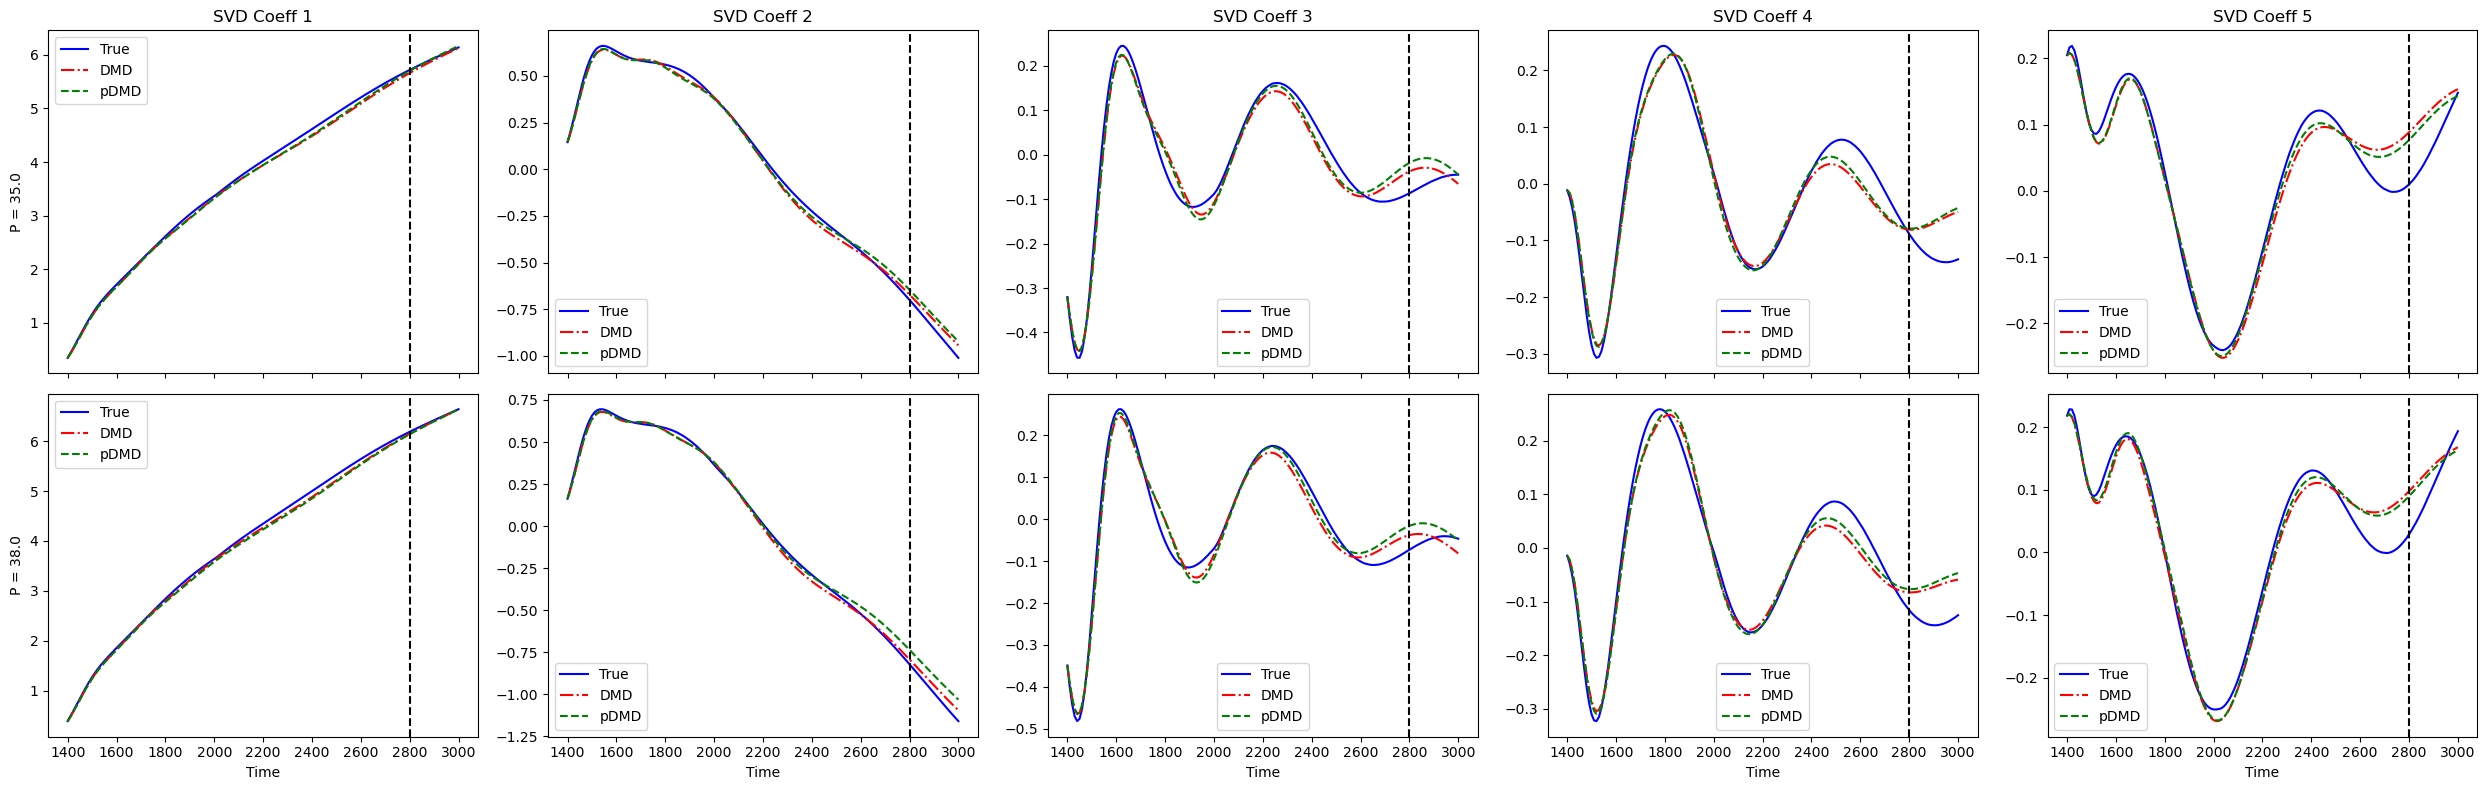

In [18]:
from pydmd import DMD

modes_to_plot = np.arange(0, 5, 1)

# Save for future use
dmds_test = dict()

fig, axs = plt.subplots(len(test_params), len(modes_to_plot), sharex=True, figsize=(len(modes_to_plot)*5, len(test_params)*4))
axs = axs.reshape(len(test_params), len(modes_to_plot))

for mu_test in range(len(test_params)):
    
    if roi.scaler is not None:
        _scaled_test_pod_coeff = roi.scaler.transform(test_pod_coeff[mu_test, :, :roi.rank].reshape(-1, roi.rank))
    else:
        _scaled_test_pod_coeff = test_pod_coeff[mu_test, :, :roi.rank].reshape(-1, roi.rank)

    _dmd_test = DMD(svd_rank=-1)
    _dmd_test.fit(_scaled_test_pod_coeff.T)

    _dmd_test.original_time["t0"]   = train_time[0]
    _dmd_test.original_time["tend"] = train_time[-1] - 1e-12
    _dmd_test.original_time["dt"]   = train_time[1]  - train_time[0]

    _dmd_test.dmd_time["t0"]   = pred_time[0]
    _dmd_test.dmd_time["tend"] = pred_time[-1] - 1e-12
    _dmd_test.dmd_time["dt"]   = pred_time[1]  - pred_time[0]

    dmds_test[mu_test] = _dmd_test

    if roi.scaler is not None:
        dmd_rec_pod_coeff   = roi.scaler.inverse_transform(_dmd_test.reconstructed_data.T.real).T
    else:
        dmd_rec_pod_coeff = _dmd_test.reconstructed_data.real
    
    predicted_pod_coeff = roi.advance(test_pod_coeff[mu_test, 0, :roi.rank], len(pred_time), test_params[mu_test])

    for ii, idx in enumerate(modes_to_plot):
        axs[mu_test, ii].plot(pred_time, test_pod_coeff[mu_test, :, idx], 'b', label='True')
        axs[mu_test, ii].plot(pred_time, dmd_rec_pod_coeff[idx], 'r-.', label='DMD')
        axs[mu_test, ii].plot(pred_time, predicted_pod_coeff[:, idx], 'g--', label='pDMD')
        axs[mu_test, ii].legend()

        if mu_test == 0:
            axs[mu_test, ii].set_title(f'SVD Coeff {idx+1}')
            
        if ii == 0:
            axs[mu_test, ii].set_ylabel(f'P = {test_params[mu_test]}')

        if mu_test == len(test_params)-1:
            axs[mu_test, ii].set_xlabel('Time')

for ax in axs.flatten():
    ax.axvline(train_time[-1], color='black', linestyle='--')

plt.tight_layout()
fig.savefig(path_res + 'pdmd_roi_test_latent_dyn.pdf', format='pdf', dpi=200, bbox_inches='tight')

Let us observed if the eigenvalues of each test DMD model are well reconstructed by the pDMD method on the complex plane

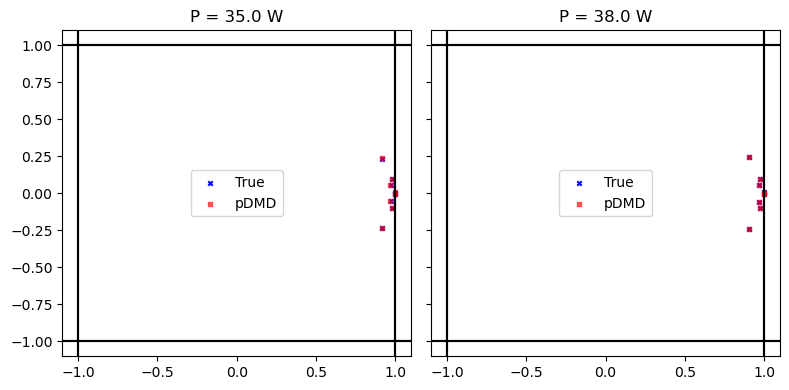

In [19]:
fig, axs = plt.subplots(1, len(test_params), sharex=True, sharey=True, figsize=(len(test_params)*4, 4))
axs = np.asarray(axs).reshape(len(test_params))

for mu_test in range(len(test_params)):

    rec_Aop = roi.predict_op(test_params[mu_test]).reshape(rank_roi, rank_roi)

    # Compute true DMD operator
    _U, _, _ = dmds_test[mu_test].operator.compute_operator(dmds_test[mu_test].snapshots[:,:-1], 
                                                            dmds_test[mu_test].snapshots[:,1:])
    true_Aop = np.linalg.multi_dot([_U, dmds_test[mu_test].operator._Atilde, _U.T])

    axs[mu_test].scatter(np.linalg.eigvals(true_Aop).real, np.linalg.eigvals(true_Aop).imag, label='True', c='b', s=10, marker='x')
    axs[mu_test].scatter(np.linalg.eigvals(rec_Aop).real, np.linalg.eigvals(rec_Aop).imag, label='pDMD', c='r', s=10, marker='s', alpha=0.6)

    axs[mu_test].set_title(f'P = {test_params[mu_test]} W')

    for ax in axs:
        ax.axvline( 1, color='k', linestyle='-')
        ax.axvline(-1, color='k', linestyle='-')
        ax.axhline( 1, color='k', linestyle='-')
        ax.axhline(-1, color='k', linestyle='-')
        ax.legend()

plt.tight_layout()

In the end, let us compare the results at the high-dimensional level

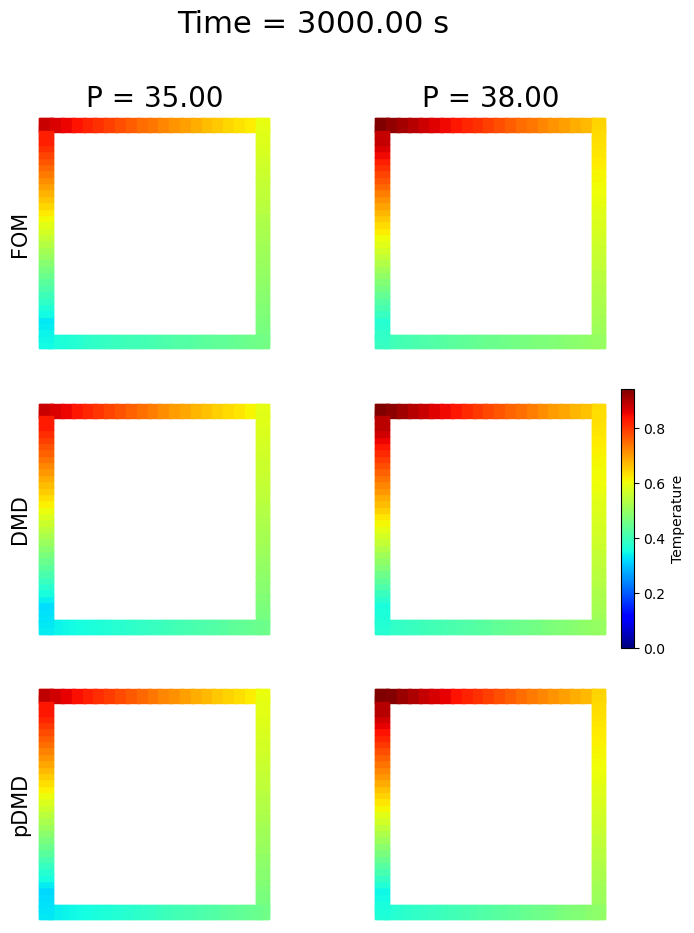

In [20]:
recons = list()

# Direct DMD
recons.append([dmd_reconstruct(dmds_test[mu_i], spatial_modes[:, :rank_roi], scaler = roi.scaler, time=None) for mu_i in range(len(test_params))])

# pDMD
recons.append(list())
for i, mu_i in enumerate(test_params):
    recons[-1].append(np.dot(spatial_modes[:, :rank_roi], 
                             roi.advance(test_pod_coeff[i, 0, :rank_roi], len(pred_time), mu_i).T))

labels = ['DMD', 'pDMD']
for tt in range(0, len(pred_time), 10):
    fig, axs = plotter.plotting_loop_rec( np.arange(0, len(test_params), 1), test_snapshots, test_params, pred_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Reduced Koopman Operator Interpolation with OptDMD (rKOp)
This version builts DMD models (with OptDMD algorithm) for each training parameters and then interpolates the DMD operators to predict the test set.

In [100]:
from tools.backends import ReducedKoopmanOperatorInterpolation
from sklearn.preprocessing import StandardScaler

rank_rkoi = 7
rkoi = ReducedKoopmanOperatorInterpolation(rank = rank_rkoi)
rkoi.fit(train_pod_coeff, train_time=train_time,
         verbose=True, tol = 0.2, opt_verbose=False, scaler=MinMaxScaler())

Let us make some contour plots of the reconstruction of the DMD models for training parameters

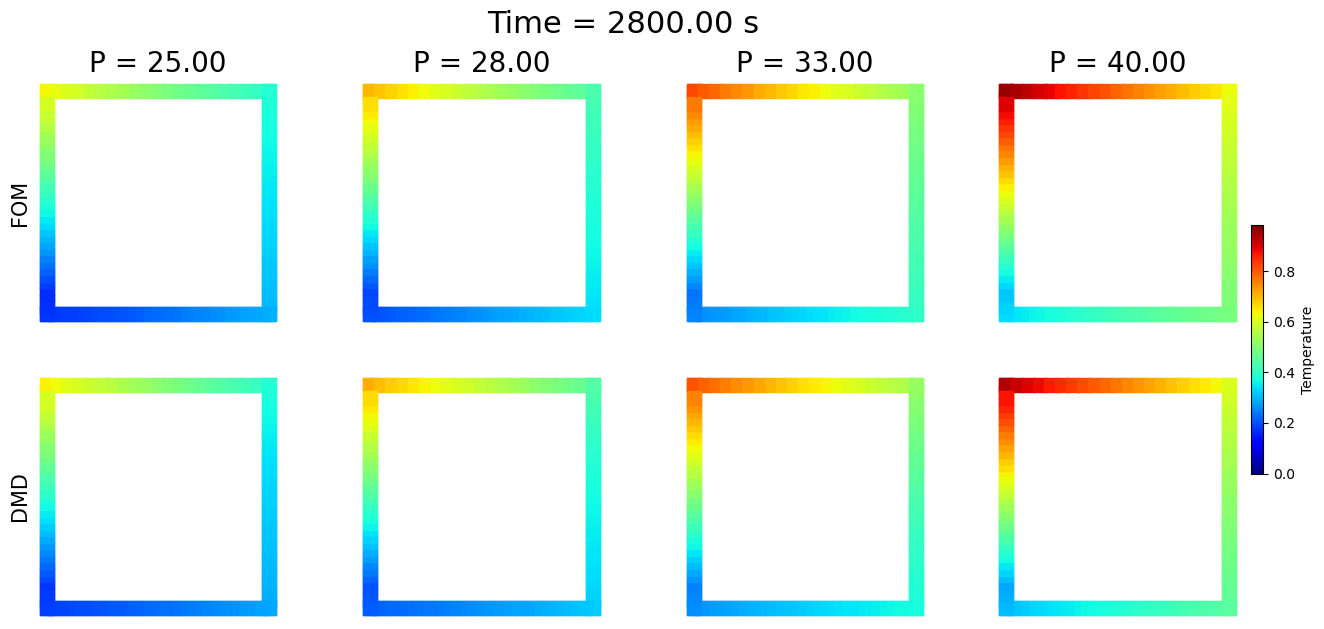

In [101]:
from tools.backends import dmd_reconstruct
from IPython.display import clear_output as clc

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_params), 4, replace=False))

recons = [[dmd_reconstruct(rkoi.dmds[mu_i], spatial_modes[:, :rkoi.rank], time=train_time, scaler=rkoi.scaler) for mu_i in params_to_plot]]
labels = ['DMD']

for tt in range(0, len(train_time), 10):
    fig, axs = plotter.plotting_loop_rec( params_to_plot, train_snapshots, train_params, train_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Once a DMD model has been built for each parametric realization, we are looking for a generic parametric representation of the DMD models.

The DMD forecasting is performed according to the following formula: to find the unknown state $\mathbf{x}(t)$
\begin{equation*}
\mathbf{x}(t) = \sum_{k=1}^{r} b_k \cdot  \boldsymbol{\phi}_k\cdot e^{\omega_k t}
\end{equation*}
where $ \boldsymbol{\phi}_k$ are the DMD modes, $\omega_k$ are the DMD eigenvalues, and $\mathbf{b}$ are the DMD amplitudes, according to https://github.com/PyDMD/PyDMD/blob/master/pydmd/bopdmd.py.


We need to interpolate the DMD modes, eigenvalues, and amplitudes to predict the test set.

In [102]:
rkoi.get_kop()
rkoi.get_kop_interpolants(train_params, interp = 'linear')

Let us compute the optimised DMD for the test set

In [103]:
from pydmd import BOPDMD

optdmds_test = dict()
for mu_test in range(len(test_params)):

    print('DMD for test parameter %d' % mu_test, end='\r')

    if rkoi.scaler is not None:
        _scaled_test_pod_coeff = rkoi.scaler.transform(test_pod_coeff[mu_test, :, :rkoi.rank].reshape(-1, rkoi.rank))
    else:
        _scaled_test_pod_coeff = test_pod_coeff[mu_test, :, :rkoi.rank].reshape(-1, rkoi.rank)

    _dmd_test = BOPDMD(
                                svd_rank=-1,
                                num_trials=0,                                    # Number of bagging trials to perform - 0 means no bagging.
                                varpro_opts_dict={"tol": 0.2, "verbose": False}, # Set convergence tolerance and use verbose updates.
                                compute_A = False,
                            )
    _dmd_test.fit(_scaled_test_pod_coeff.T, pred_time)

    optdmds_test[mu_test] = _dmd_test


Let us observe if the latent dynamics is well reconstructed by the pDMD method for test parameters

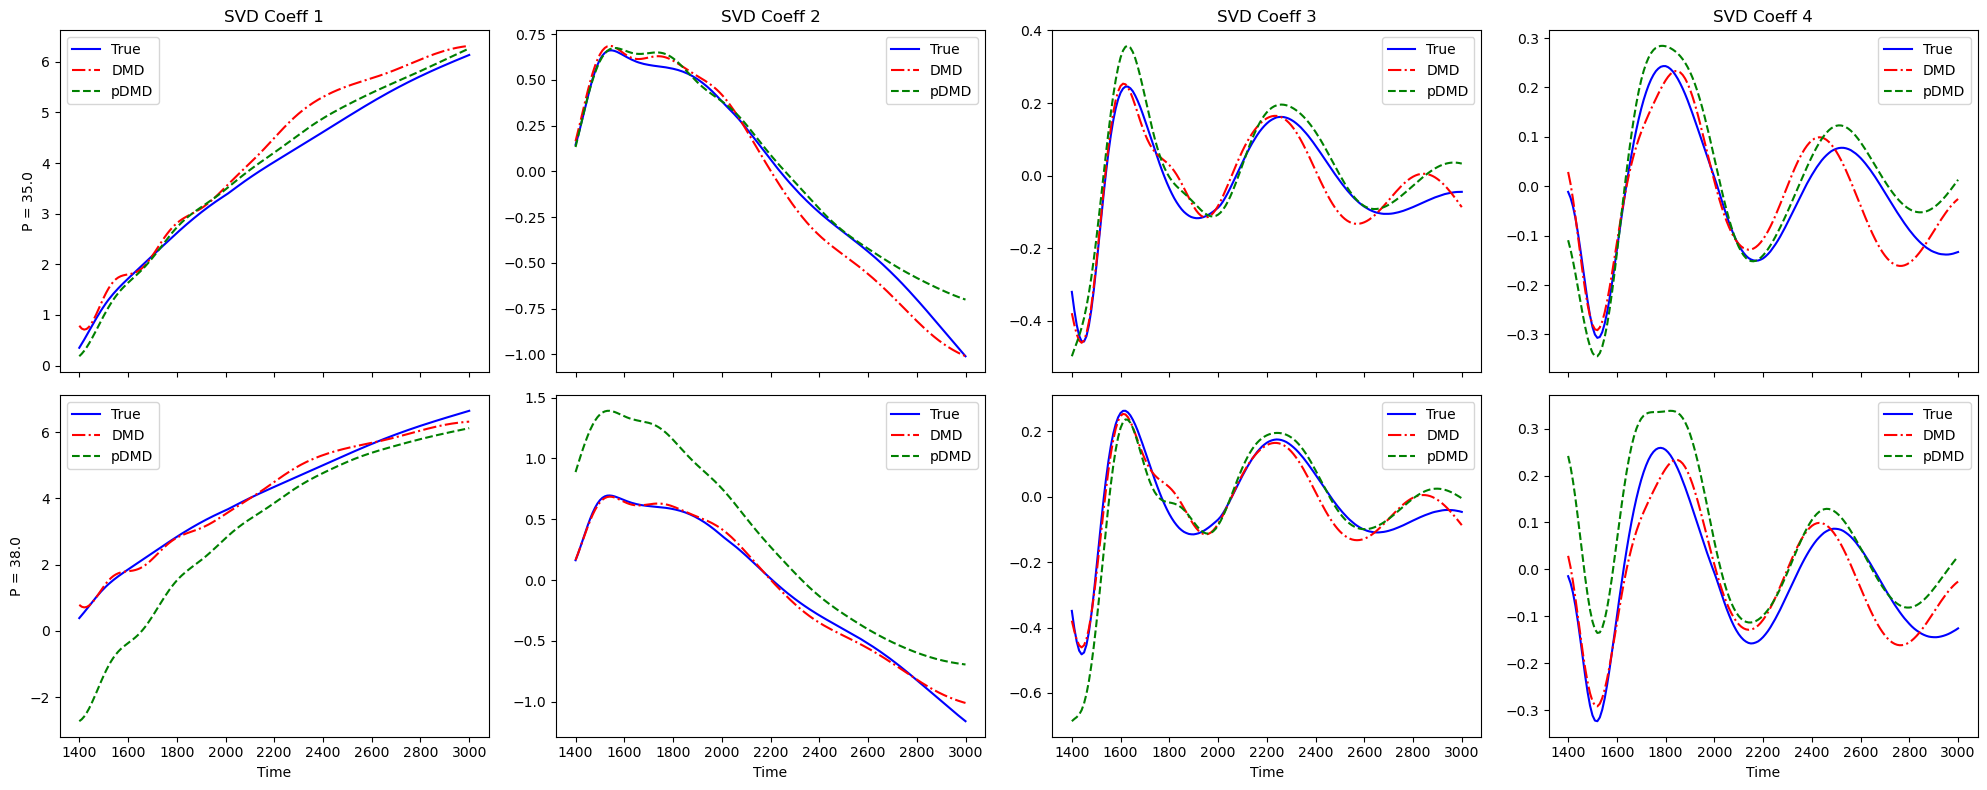

In [104]:
modes_to_plot = np.arange(0, 4, 1)

fig, axs = plt.subplots(len(test_params), len(modes_to_plot), sharex=True, figsize=(len(modes_to_plot)*5, len(test_params)*4))

for mu_test in range(len(test_params)):

    if rkoi.scaler is not None: 
        dmd_rec_pod_coeff   = rkoi.scaler.inverse_transform(_dmd_test.forecast(pred_time).real.T).T
    else:
        dmd_rec_pod_coeff = _dmd_test.forecast(pred_time).real

    model = {
            'modes': optdmds_test[mu_test].modes,
            'amplitudes': optdmds_test[mu_test].amplitudes,
            'eigs': optdmds_test[mu_test].eigs,
        }
    pred_model = rkoi.predict_kop(test_params[mu_test])
    predicted_pod_coeff = rkoi.forecast(pred_model, pred_time)

    for ii, idx in enumerate(modes_to_plot):
        axs[mu_test, ii].plot(pred_time, test_pod_coeff[mu_test, :, idx], 'b', label='True')
        axs[mu_test, ii].plot(pred_time, dmd_rec_pod_coeff[idx], 'r-.', label='DMD')
        axs[mu_test, ii].plot(pred_time, predicted_pod_coeff[idx], 'g--', label='pDMD')
        axs[mu_test, ii].legend()

        if mu_test == 0:
            axs[mu_test, ii].set_title(f'SVD Coeff {idx+1}')
            
        if ii == 0:
            axs[mu_test, ii].set_ylabel(f'P = {test_params[mu_test]}')

        if mu_test == len(test_params)-1:
            axs[mu_test, ii].set_xlabel('Time')

plt.tight_layout()
fig.savefig(path_res + 'pdmd_rkoi_test_latent_dyn.pdf', format='pdf', dpi=200, bbox_inches='tight')


Let us decode to the high-dimensional space and compare the results

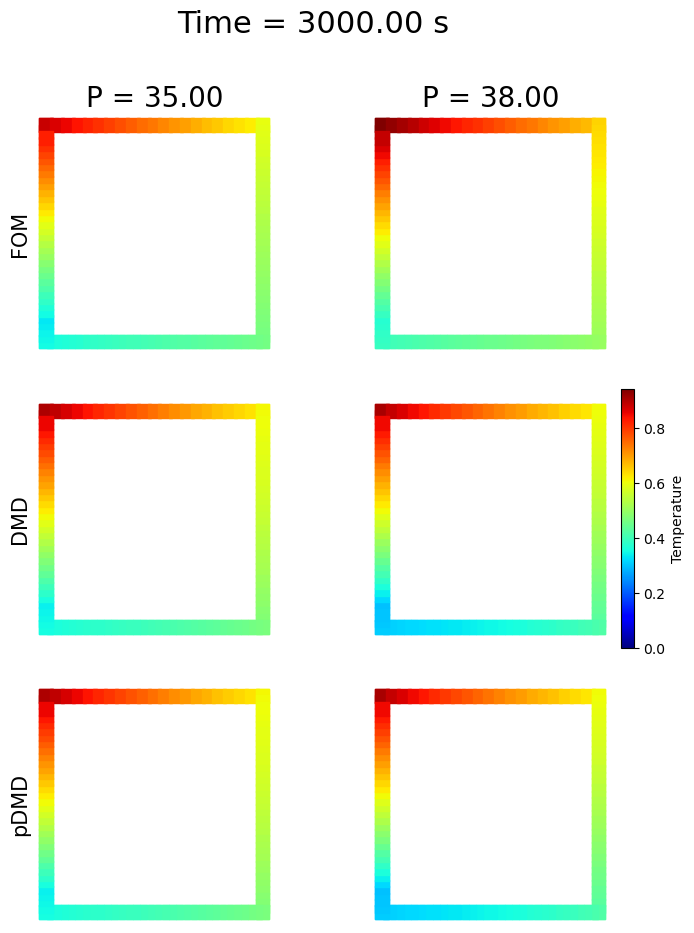

In [105]:
recons = [list()]*2
for i, mu_i in enumerate(test_params):

    if rkoi.scaler is not None:
        dmd_rec_pod_coeff   = rkoi.scaler.inverse_transform(_dmd_test.forecast(pred_time).real.T).T
    else:
        dmd_rec_pod_coeff   = _dmd_test.forecast(pred_time).real

    true_model = {
                'modes': optdmds_test[mu_test].modes,
                'amplitudes': optdmds_test[mu_test].amplitudes,
                'eigs': optdmds_test[mu_test].eigs,
            }

    pred_model = rkoi.predict_kop(test_params[mu_test])
    predicted_pod_coeff = rkoi.forecast(pred_model, pred_time)

    recons[0].append(spatial_modes[:, :rkoi.rank] @ dmd_rec_pod_coeff)
    recons[1].append(spatial_modes[:, :rkoi.rank] @ predicted_pod_coeff)

labels = ['DMD', 'pDMD']
for tt in range(0, len(pred_time), 10):
    fig, axs = plotter.plotting_loop_rec( np.arange(0, len(test_params), 1), test_snapshots, test_params, pred_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Monolithic pDMD from pyDMD - pDMD-mono
This version is embedded in pyDMD and is used to build a single DMD model for all the training parameters.

In [65]:
from pydmd import ParametricDMD, DMD
from ezyrb import POD, RBF
import warnings
warnings.filterwarnings("ignore")

interpolator = RBF()

rank_monolithic = 5
rom_monolithic  = POD(rank=rank_monolithic, method='randomized_svd')

dmd_monolithic  = DMD(svd_rank=-1)
pdmd_monolithic = ParametricDMD(dmd_monolithic, rom_monolithic, interpolator)

Let us train the monolithic model with the snapshot has to be re-arranged as follows

\begin{equation*}
  N_p \times N_h \times N_{t}
\end{equation*}

In [66]:
pdmd_monolithic.fit(
    np.swapaxes(train_snapshots, 1, 2), 
    train_params
)

Let us assign the time to the monolithic DMD mode

In [67]:
pdmd_monolithic.original_time["t0"]   = train_time[0]
pdmd_monolithic.original_time["tend"] = train_time[-1] - 1e-12
pdmd_monolithic.original_time["dt"]   = train_time[1]  - train_time[0]

pdmd_monolithic.dmd_time["t0"]   = pred_time[0]
pdmd_monolithic.dmd_time["tend"] = pred_time[-1] - 1e-12
pdmd_monolithic.dmd_time["dt"]   = pred_time[1]  - pred_time[0]

Let us make some contour plots of the reconstruction of the DMD models for training parameters

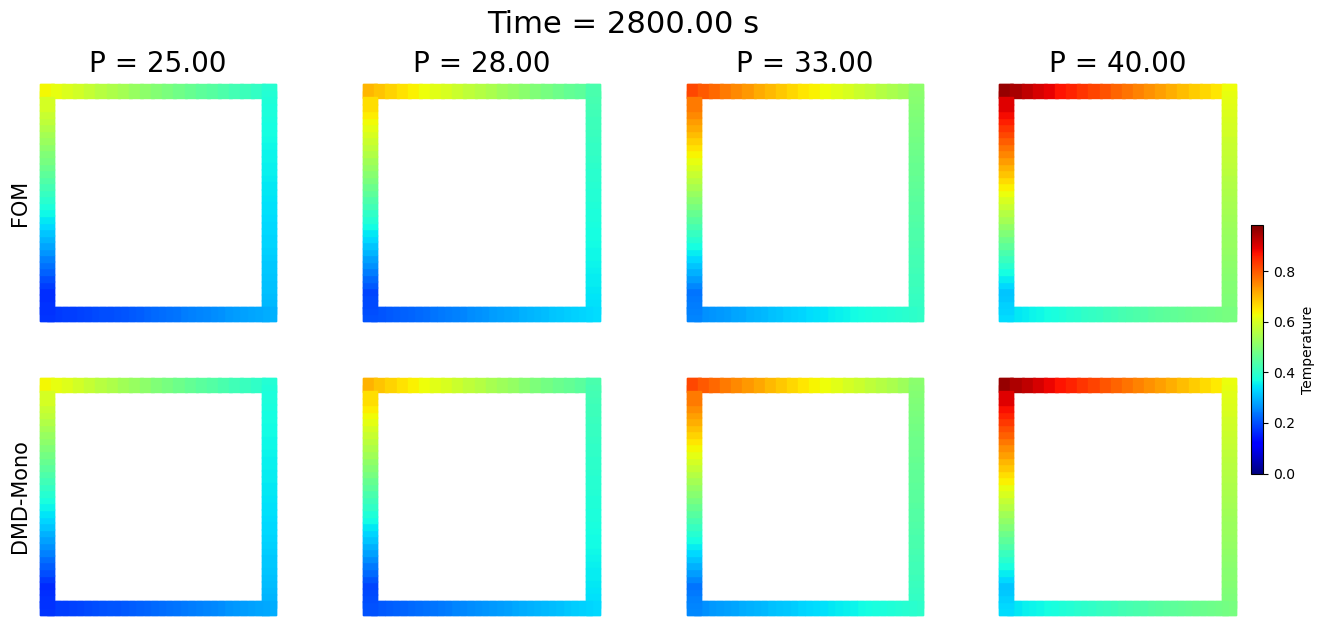

In [68]:
from IPython.display import clear_output as clc

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_params), 4, replace=False))

recons = [list()]
for mu_i in params_to_plot:
    idx_to_rec = np.arange(rank_monolithic * mu_i, rank_monolithic * (mu_i+1))
    recons[-1].append(pdmd_monolithic._spatial_pod.modes @ pdmd_monolithic._dmd.reconstructed_data[idx_to_rec])

labels = ['DMD-Mono']

for tt in range(0, len(train_time), 10):
    fig, axs = plotter.plotting_loop_rec( params_to_plot, train_snapshots, train_params, train_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Let us test the model on the test set of parameters

In [69]:
pdmd_monolithic.parameters  = test_params
recon_monolithic  = pdmd_monolithic.reconstructed_data.real

Let us plot the results

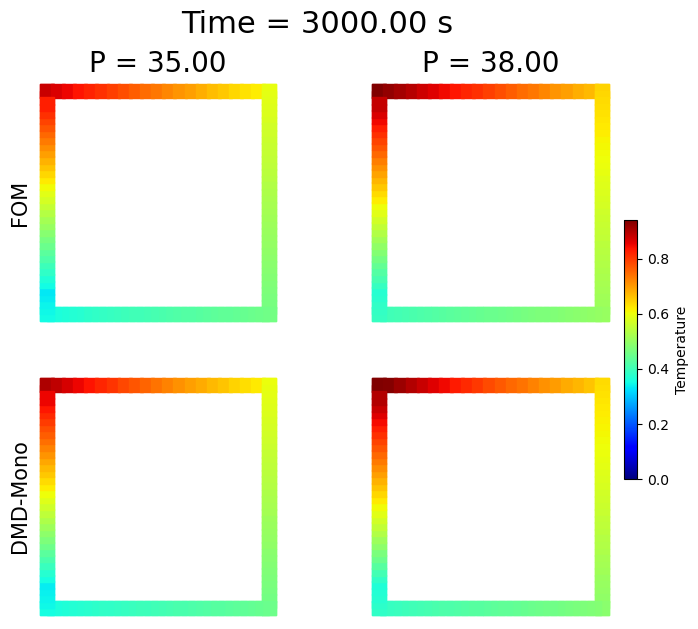

In [70]:
recons = [list()]
for mu_i in range(len(test_params)):
    recons[-1].append(recon_monolithic[mu_i])

labels = ['DMD-Mono']

for tt in range(0, len(pred_time), 10):
    fig, axs = plotter.plotting_loop_rec( np.arange(0, len(test_params), 1), test_snapshots, test_params, pred_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Partitioned pDMD from pyDMD - pDMD-mono
This version is embedded in pyDMD and is similar to the ROI, the output of the training DMD models is interpolated.

In [73]:
from pydmd import ParametricDMD, DMD, HankelDMD
from ezyrb import POD, RBF
import warnings
warnings.filterwarnings("ignore")

interpolator = RBF()

rank_partitioned = 5
rom_partitioned  = POD(rank=rank_partitioned, method='randomized_svd')
dmds_partitioned = [DMD(svd_rank=-1) for _ in range(len(train_params))]

pdmd_partitioned = ParametricDMD(dmds_partitioned, rom_partitioned, interpolator)

Let us train the monolithic model with the snapshot has to be re-arranged as follows

\begin{equation*}
  N_p \times N_h \times N_{t}
\end{equation*}

In [74]:
pdmd_partitioned.fit(
    np.swapaxes(train_snapshots, 1, 2), 
    train_params
)

Let us assign the time to the partitioned DMD mode

In [75]:
pdmd_partitioned.original_time["t0"]   = train_time[0]
pdmd_partitioned.original_time["tend"] = train_time[-1] - 1e-12
pdmd_partitioned.original_time["dt"]   = train_time[1]  - train_time[0]

pdmd_partitioned.dmd_time["t0"]   = pred_time[0]
pdmd_partitioned.dmd_time["tend"] = pred_time[-1] - 1e-12
pdmd_partitioned.dmd_time["dt"]   = pred_time[1]  - pred_time[0]

Let us make some contour plots of the reconstruction of the DMD models for training parameters

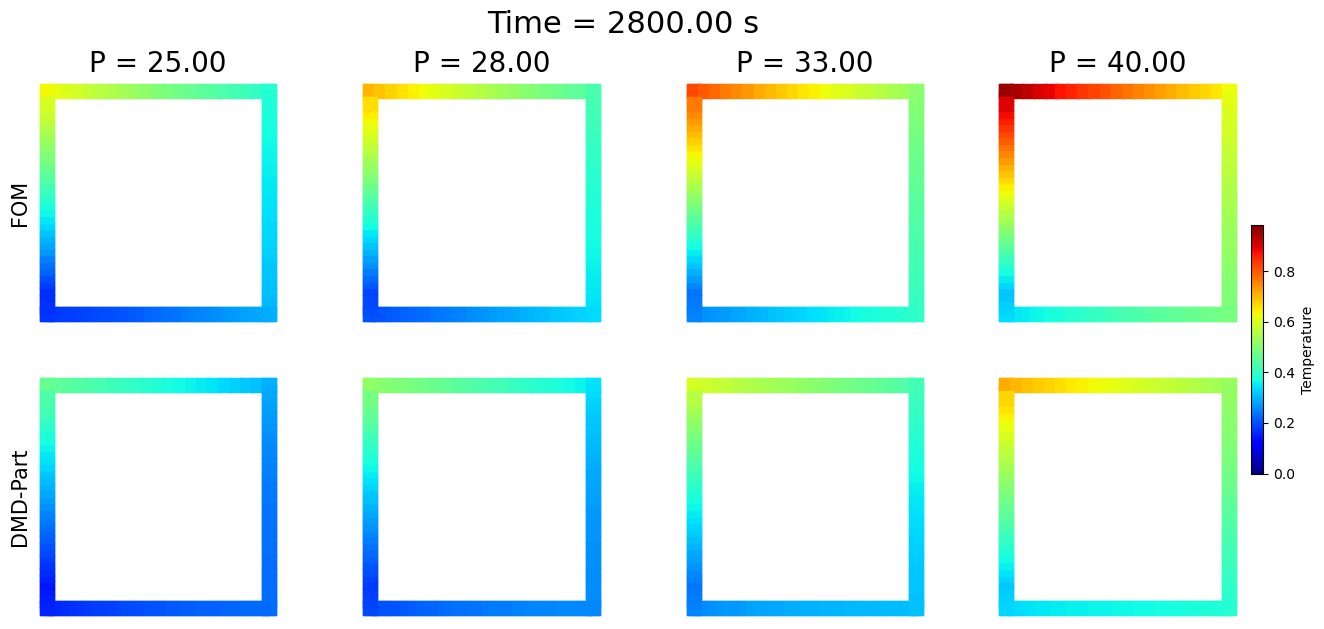

In [76]:
from IPython.display import clear_output as clc

np.random.seed(4)
params_to_plot = np.sort(np.random.choice(len(train_params), 4, replace=False))

recons = [list()]
for mu_i in params_to_plot:
    idx_to_rec = np.arange(rank_partitioned * mu_i, rank_partitioned * (mu_i+1))
    recons[-1].append(pdmd_partitioned._spatial_pod.modes @ pdmd_partitioned._dmd[mu_i].reconstructed_data)

labels = ['DMD-Part']

for tt in range(0, len(train_time), 10):
    fig, axs = plotter.plotting_loop_rec( params_to_plot, train_snapshots, train_params, train_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

Let us test the model on the test set of parameters

In [77]:
pdmd_partitioned.parameters  = test_params
recon_partitioned  = pdmd_partitioned.reconstructed_data.real

Let us plot the results

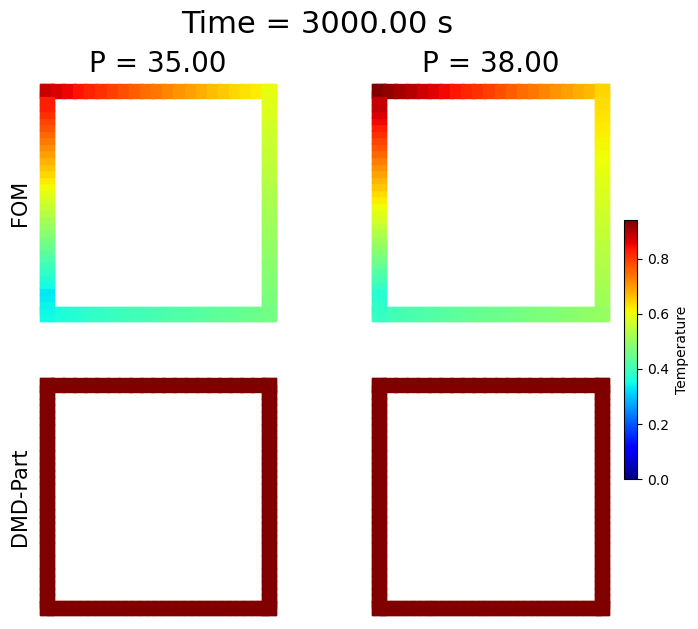

In [78]:
recons = [list()]
for mu_i in range(len(test_params)):
    recons[-1].append(recon_partitioned[mu_i])

labels = ['DMD-Part']

for tt in range(0, len(pred_time), 10):
    fig, axs = plotter.plotting_loop_rec( np.arange(0, len(test_params), 1), test_snapshots, test_params, pred_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4)
    
    clc(wait=True)
    plt.show()
    plt.close(fig)

## Comparison of the different methods
In this last section, the test set will be used to compare the different methods.
The Euclidian norm is taken spatially of the residual field between the predicted and the actual field, then the time and parameter average is made.

In [106]:
from matplotlib.colors import Normalize
from tqdm import tqdm
from time import process_time

# labels = ['ROI', 'RKOI', 'Monolithic', 'Partitioned']
labels = ['ROI', 'RKOI', 'Monolithic']
recons = [list() for _ in range(len(labels))]
compt_times = np.zeros((len(test_params), len(labels)))

for ii, mu in enumerate(test_params):

    # Reduced Operator Interpolation (ROI)
    start = process_time()
    recons[0].append(np.dot(spatial_modes[:, :roi.rank], 
                            roi.advance(test_pod_coeff[ii, 0, :roi.rank], len(pred_time), mu).T))
    compt_times[ii, 0] = process_time() - start

    # Reduced Koopman Operator Interpolation (RKOI)
    start = process_time()
    pred_model = rkoi.predict_kop(mu)
    predicted_pod_coeff = rkoi.forecast(pred_model, pred_time)
    recons[1].append(spatial_modes[:, :rkoi.rank] @ predicted_pod_coeff)
    compt_times[ii, 1] = process_time() - start

    # Monolithic DMD
    start = process_time()
    pdmd_monolithic.parameters = [mu]
    recons[2].append(pdmd_monolithic.reconstructed_data.real)
    compt_times[ii, 2] = process_time() - start

    # # Partitioned DMD
    # start = process_time()
    # pdmd_partitioned.parameters = [mu]
    # recons[3].append(pdmd_partitioned.reconstructed_data.real)
    # compt_times[ii, 3] = process_time() - start

In [107]:
_recons = recons.copy()

for ii in range(len(test_params)):
    # print(recons[0][ii].shape, recons[1][ii].shape, recons[2][ii].shape, recons[3][ii].shape)
    print(recons[0][ii].shape, recons[1][ii].shape, recons[2][ii].shape)

for ii in range(len(test_params)):
    recons[2][ii] = _recons[2][ii][0]
    # recons[3][ii] = _recons[3][ii][0]
    # recons[3][ii] = np.concatenate([_recons[3][ii], _recons[3][ii][:, -1].reshape(-1,1)], axis=1)
    
for ii in range(len(test_params)):
    # print(recons[0][ii].shape, recons[1][ii].shape, recons[2][ii].shape, recons[3][ii].shape)
    print(recons[0][ii].shape, recons[1][ii].shape, recons[2][ii].shape)


(122, 161) (122, 161) (1, 122, 161)
(122, 161) (122, 161) (1, 122, 161)
(122, 161) (122, 161) (122, 161)
(122, 161) (122, 161) (122, 161)


Here the errors are computed

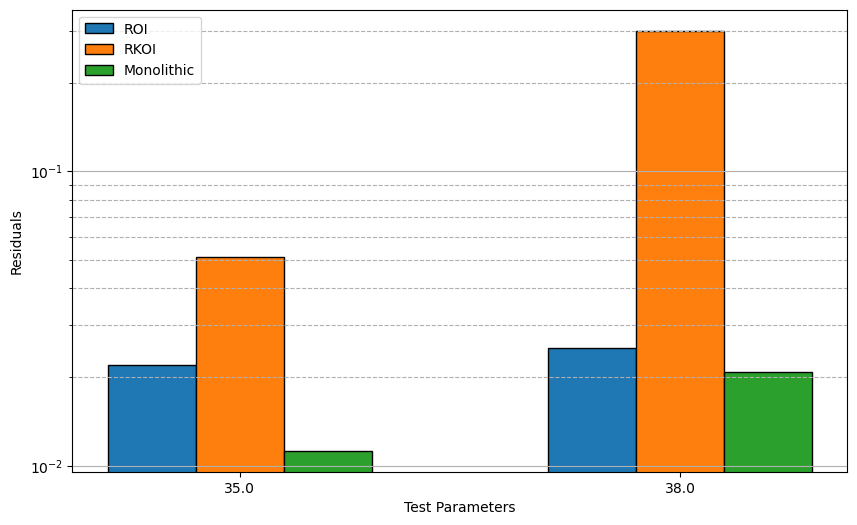

In [108]:
resids = np.zeros((len(test_params), len(labels)))

for ii in range(len(test_params)):
    for jj in range(len(labels)):
        resids[ii, jj] = np.linalg.norm(recons[jj][ii] - test_snapshots[ii].T) / np.linalg.norm(test_snapshots[ii].T)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
positions = np.arange(len(test_params))

for i, label in enumerate(labels):
    ax.bar(positions + i * bar_width, resids[:, i], bar_width, label=label, edgecolor='black')

ax.set_yscale('log')
ax.set_xlabel('Test Parameters')
ax.set_ylabel('Residuals')
ax.grid(which='major', linestyle='-', axis='y')
ax.grid(which='minor', linestyle='--', axis='y')

ax.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
ax.set_xticklabels(test_params)
ax.legend()

fig.savefig(path_res + 'residual_errors.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [109]:
for i, param in enumerate(test_params):
    print(f"Parameter: {param} W")
    for j, label in enumerate(labels):
        print(f"Algorithm: {label}, Residual: {resids[i, j]} - CPU Time (s): {compt_times[i, j]}")
    print()

Parameter: 35.0 W
Algorithm: ROI, Residual: 0.021937901196587933 - CPU Time (s): 0.005418077999934212
Algorithm: RKOI, Residual: 0.05097620857570293 - CPU Time (s): 0.005643082000005961
Algorithm: Monolithic, Residual: 0.011232290013459151 - CPU Time (s): 1.2291270340000437

Parameter: 38.0 W
Algorithm: ROI, Residual: 0.025033303816898164 - CPU Time (s): 0.01086778499995944
Algorithm: RKOI, Residual: 0.30055816461012685 - CPU Time (s): 0.021779152000021895
Algorithm: Monolithic, Residual: 0.02083066525243796 - CPU Time (s): 0.9503936849999945



Let us generate the frames and make the video

In [110]:
from tools.plots import make_mp4, make_gif

# Define colorbar
vmin = test_snapshots.min()
vmax = test_snapshots.max()

cmap = cmap
norm = Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

# Define fig path
path_fig = path_res+'Figs/'
os.makedirs(path_fig, exist_ok=True)

for tt in tqdm(range(0, len(pred_time), 1)):
    fig, axs = plotter.plotting_loop_rec( np.arange(0, len(test_params), 1), test_snapshots, test_params, pred_time, tt, 
                            recons = recons, labels = labels, cmap = cmap, show_residuals=False, length_plot=4, show_cb=False)


    # Create a new axis for the colorbar below the title
    cbar_ax = fig.add_axes([0.05, 0.92, 0.9, 0.01])  # [left, bottom, width, height] in figure coordinates
    cbar = fig.colorbar(scalar_mappable, cax=cbar_ax, orientation='horizontal', shrink=0.9)
    cbar.set_label('Temperature (-)')

    cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
    cbar.ax.xaxis.set_label_position('top')  # Move label to the top

    fig.savefig(path_fig + f'comparison_{tt:04d}.png', format='png', dpi=200, bbox_inches='tight')
    plt.close(fig)

path_video = 'SupportingVideos/'
os.makedirs(path_video, exist_ok=True)

make_mp4(path_fig, path_video+'dynasty1param_video.mp4', fps=25)
# make_gif(path_fig, path_video+'dynasty1param_video.gif', fps=25)

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [00:58<00:00,  2.73it/s]
[_io.py:561 -         write_frames() ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1502, 2476) to (1504, 2480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x445a5280] Warning: data is not aligned! This can lead to a speed loss
